<img src=https://upload.wikimedia.org/wikipedia/commons/1/19/UDLA-logo-oficial.jpg width=400/>

# Fundamentos de Data Science con Python
**Dr. Julio Lopez-Nunez (2025)**

## **Sesión 2 – EDA**
**Duración total estimada:** 180 min  


## ⏱️ 1) Objetivos (15 min)
- Comprender el propósito del **Análisis Exploratorio de Datos (EDA)**.  
- Detectar y tratar **valores faltantes**, **duplicados**, **tipos inconsistentes** y **outliers**.  
- Aplicar **limpieza básica** con `pandas`.  
- Generar **visualizaciones** con `matplotlib` y `seaborn`.  
- Dejar criterios de **buenas prácticas** para interpretar resultados.
> Nota: Este notebook es el complemento práctico del PPT_2.

## ⏱️ 2) Etapas tradicionalmente ejecutadas

Aplicamos **EDA pre y post** para comprender los datos en bruto y validar los cambios tras la limpieza y transformación.



### 2.1 Recolección de Datos
Los datos se recopilan de diversas fuentes: bases de datos, archivos, sensores, etc.

    import pandas as pd
    df = pd.read_csv("datos_estudiantes_200_eda.csv")
    df.head()

### 2.2 Limpieza de Datos
Este paso implica eliminar errores, datos duplicados y valores faltantes para mejorar la calidad de los datos.

    # Eliminar duplicados
    df = df.drop_duplicates()

    # Conteo de valores faltantes
    df.isna().sum()

### 2.3 Transformación de Datos
Los datos se transforman a un formato adecuado para el análisis: normalización, agregación y selección de características.

    # Normalización simple de columna (ejemplo)
    df["Nota_Final"] = df["Nota_Final"] / df["Nota_Final"].max()

### 2.4 Visualizaciones
Analizar de forma visual cómo se presentan los datos. Esto permite detectar patrones y anomalías iniciales que orientan decisiones posteriores.

    import seaborn as sns
    sns.histplot(df["Nota_Final"])

### 2.5 EDA final
Después de la limpieza y transformación, realizamos un EDA más completo. Además del trabajo manual con **pandas** y **seaborn**, podemos generar un **EDA automático** con la librería **ydata-profiling** (antes *pandas-profiling*), que produce un informe HTML con estadísticas, distribuciones, correlaciones y alertas de calidad.

    # En Colab: instalar si es necesario
    # !pip install ydata-profiling

    from ydata_profiling import ProfileReport
    profile = ProfileReport(df, title="Reporte EDA Automático", explorative=True)
    profile.to_notebook_iframe()

## ⏱️ 3) Vista general del dataset (10 min)

In [ ]:
#Cargar datos (Ejemplo2.csv)
from google.colab import files
uploaded = files.upload()

Saving Ejemplo2.csv to Ejemplo2.csv


In [ ]:
#Definir una variable para cargar los datos del fichero Ejemeplo2.csv
import pandas as pd
df = pd.read_csv("Ejemplo2.csv")

In [ ]:
df.shape, df.dtypes

((31, 6),
 ID                int64
 Nombre           object
 Edad            float64
 Carrera          object
 Nota_Final       object
 Asistencia_%     object
 dtype: object)

In [ ]:
df.sample(5, random_state=1) #random_state permite definir que los registros aleatorios siempre sean los mismos

,ID,Nombre,Edad,Carrera,Nota_Final,Asistencia_%
27,28,Estudiante28,22.0,Física,4.1,83
3,4,Estudiante4,29.0,física,NaN,NaN
19,20,Estudiante20,22.0,Física,3.6,74
23,24,Estudiante24,24.0,Educación,5.6,68
22,23,Estudiante23,20.0,Matemática,5.9,66


## ⏱️ 4) Calidad de datos: faltantes, duplicados y tipos (25–30 min)

In [ ]:

# Conteo de duplicados
dup_count = df.duplicated().sum()
print("Duplicados:", dup_count)

# Faltantes por columna
print("\nFaltantes por columna:")
print(df.isna().sum())

# Tipos detectados automáticamente
df.dtypes


Duplicados: 1

Faltantes por columna:
ID              0
Nombre          0
Edad            2
Carrera         1
Nota_Final      1
Asistencia_%    1
dtype: int64


,0
ID,int64
Nombre,object
Edad,float64
Carrera,object
Nota_Final,object
Asistencia_%,object



### Conversión de tipos (si hay texto en numéricos)
Objetivo: normalizar `Nota_Final` y `Asistencia_%` ante comas decimales, "%", "NA", "s/d", etc.


In [ ]:

import numpy as np
import pandas as pd

def normalizar_nota(s):
    # Convierte comas a puntos y "NA" a NaN; luego a numérico
    s = s.astype(str).str.replace(",", ".", regex=False).replace({"NA": np.nan, "NaN": np.nan})
    return pd.to_numeric(s, errors="coerce") # COERCE: si no puede convertir, lo transforma en NaN (valor faltante).

def normalizar_asistencia(s):
    # Quita '%' y mapea 's/d' a NaN; luego a numérico
    s = s.astype(str).str.replace("%", "", regex=False).replace({"s/d": np.nan, "S/D": np.nan})
    return pd.to_numeric(s, errors="coerce") #Otras alternativas a CORCE: raise, ignore

work = df.copy()
if "Nota_Final" in work.columns:
    work["Nota_Final"] = normalizar_nota(work["Nota_Final"])
if "Asistencia_%" in work.columns:
    work["Asistencia_%"] = normalizar_asistencia(work["Asistencia_%"])

work.dtypes


,0
ID,int64
Nombre,object
Edad,float64
Carrera,object
Nota_Final,float64
Asistencia_%,float64



### Tratamiento de duplicados y faltantes (15–20 min)
Estrategias comunes:
- Eliminar duplicados exactos: `drop_duplicates()`  
- Imputación simple (mediana/media/moda) o eliminación de filas con `dropna()`  
- Documentar decisiones.


In [ ]:

# Eliminar duplicados
work = work.drop_duplicates() # Elimina filas (completamente) repetidas

# Imputaciones simples
for col in ["Nota_Final", "Asistencia_%"]:
    if col in work.columns:
        mediana = work[col].median(skipna=True) # rellena NaN en columnas numéricas utilizando la mediana
        work[col] = work[col].fillna(mediana)

# Ejemplo para Carrera (modo) + normalizar formato
if "Carrera" in work.columns:
    moda_carrera = work["Carrera"].mode(dropna=True) # limpia categorías como Carrera. Rellena NaN con moda
    if len(moda_carrera) > 0:
        work["Carrera"] = work["Carrera"].fillna(moda_carrera.iloc[0]).astype(str).str.strip().str.title()

# Normalizar 'Nombre' (espacios)
if "Nombre" in work.columns:
    work["Nombre"] = work["Nombre"].astype(str).str.strip()

# astype(str): asegura que todos sean strings.
# str.strip(): elimina espacios extra al inicio o final.
# str.title(): pone mayúscula inicial (ej. "matemática" → "Matemática").

work.isna().sum()

,0
ID,0
Nombre,0
Edad,2
Carrera,0
Nota_Final,0
Asistencia_%,0



### Detección y manejo de outliers (15–20 min)
- Escala de `Nota_Final` esperada: **1.0 a 7.0**.  
- Decisión de manejo: recortar (cap), imputar, o eliminar según contexto.


In [ ]:

# Identificar outliers en Nota_Final
if "Nota_Final" in work.columns:
    outliers_mask = (work["Nota_Final"] < 1.0) | (work["Nota_Final"] > 7.0) #Se crea una serie booleana (True/False) que marca como True los valores que estén fuera del rango válido de notas (1.0 a 7.0
    print("Outliers detectados en Nota_Final:", int(outliers_mask.sum()))
    # Ejemplo de recorte (cap), tambien conocido como capping o winsorización
    work.loc[work["Nota_Final"] < 1.0, "Nota_Final"] = 1.0
    work.loc[work["Nota_Final"] > 7.0, "Nota_Final"] = 7.0
    # En las dos anteriores lineas los valores menores a 1.0 se reemplazan por 1.0.
    # y los valores mayores a 7.0 se reemplazan por 7.0.


Outliers detectados en Nota_Final: 0


## ⏱️ 5) Resumen estadístico y checks (10–15 min)

In [ ]:
work.describe(include='all')

,ID,Nombre,Edad,Carrera,Nota_Final,Asistencia_%
count,30.000000,30,28.000000,30,30.000000,30.000000
unique,NaN,30,NaN,7,NaN,NaN
top,NaN,Estudiante1,NaN,Ingeniería,NaN,NaN
freq,NaN,1,NaN,7,NaN,NaN
mean,15.500000,NaN,26.178571,NaN,4.933333,76.933333
std,8.803408,NaN,5.436867,NaN,1.319374,12.627101
min,1.000000,NaN,19.000000,NaN,1.000000,55.000000
25%,8.250000,NaN,22.000000,NaN,4.100000,67.250000
50%,15.500000,NaN,25.000000,NaN,4.950000,78.000000
75%,22.750000,NaN,28.000000,NaN,5.825000,84.750000



## ⏱️ 6) Visualización (35–40 min)
Nota: en Colab puede requerir `pip install seaborn` si no estuviera disponible.


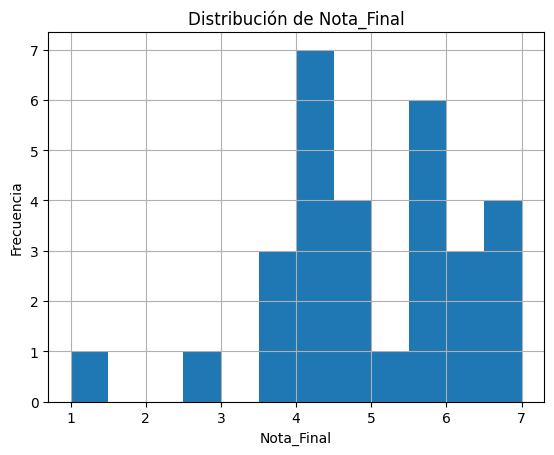

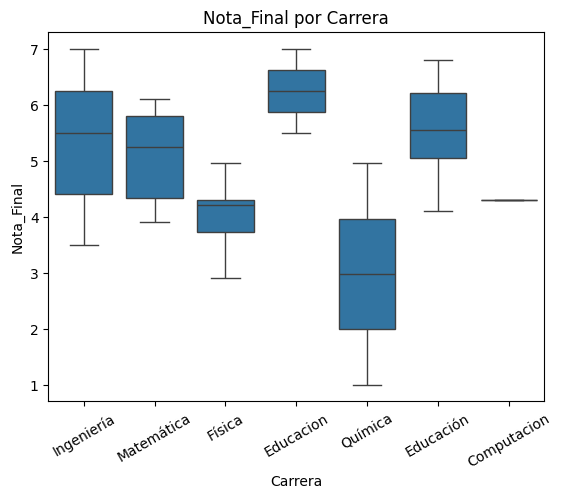

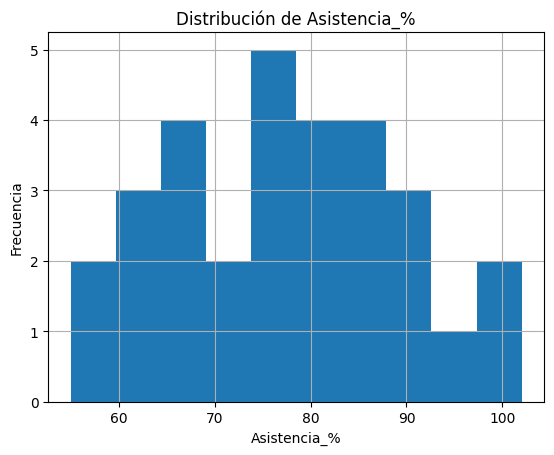

In [ ]:

# !pip install seaborn  # (descomentar si es necesario)
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de Nota_Final
plt.figure()
work["Nota_Final"].hist(bins=12)
plt.title("Distribución de Nota_Final")
plt.xlabel("Nota_Final")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot de Nota_Final por Carrera
plt.figure()
sns.boxplot(data=work, x="Carrera", y="Nota_Final")
plt.title("Nota_Final por Carrera")
plt.xlabel("Carrera"); plt.ylabel("Nota_Final")
plt.xticks(rotation=30)
plt.show()

# Histograma de Asistencia_%
plt.figure()
work["Asistencia_%"].hist(bins=10)
plt.title("Distribución de Asistencia_%")
plt.xlabel("Asistencia_%")
plt.ylabel("Frecuencia")
plt.show()


## ⏱️ 7) EDA final (35–40 min)
Recuerda, tambien es posible automatizar el EDA.

In [ ]:
# En Colab: instalar si es necesario
!pip install ydata-profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(work, title="Reporte EDA Automático", explorative=True)
profile.to_notebook_iframe()
#from google.colab import files
profile.to_file("eda_report.html")

## ⏱️ 8) Actividad práctica (50–60 min)




**Instrucciones:**

1. **Importar CSV (200 filas “con problemas”):**  
   Usa `datos_estudiantes_200_eda.csv` (o súbelo en Colab).  
   Sugiérenles ejecutar un EDA preliminar con: `df.head()`, `df.info()`, `df.describe()`.

2. **Diagnóstico de calidad (rápido):**  
   - Faltantes: `df.isna().sum()`  
   - Duplicados: `df.duplicated().sum()`  
   - Tipos: `df.dtypes`  
   - ¿Hay números como texto? (e.g., `"6,5"`, `"85%"`, `"s/d"`, `"NA"`)

3. **Limpieza mínima viable:**  
   - **Duplicados:** `df = df.drop_duplicates()`  
   - **Normalización numérica:**  
     - `Nota_Final`: reemplaza coma→punto y convierte a numérico con `pd.to_numeric(..., errors="coerce")`.  
     - `Asistencia_%`: elimina `%` y convierte con `pd.to_numeric(..., errors="coerce")`.  
   - **Imputación:**  
     - Numéricos → **mediana** (p.ej. `df["Nota_Final"].fillna(df["Nota_Final"].median(), inplace=True)`)  
     - Categóricos → **moda** (p.ej. `df["Carrera"].fillna(df["Carrera"].mode()[0], inplace=True)`)  
   - **Texto consistente:** `str.strip()` y `str.title()` en `Carrera` / `Nombre`.

4. **Outliers (decisión guiada):**  
   - Considera válido `Nota_Final ∈ [1.0, 7.0]`.  
   - Elige estrategia: **recortar (cap)**, **eliminar** o **dejar documentado**.

5. **Medidas y checks:**  
   - Tendencia/dispersión tras limpieza: `df[["Nota_Final","Asistencia_%"]].describe()`  
   - Por carrera: `df.groupby("Carrera")["Nota_Final"].agg(["mean","median","std","count"])`

6. **Visualizaciones (3 mínimas):**  
   - Histograma de **Nota_Final**  
   - Histograma de **Asistencia_%**  
   - **Boxplot** de `Nota_Final` por `Carrera`  
   *(Usar matplotlib/seaborn; añadir títulos y ejes claros.)*

7. **(Opcional)** Exporta el dataset limpio para la próxima sesión:  
   `df.to_csv("datos_estudiantes_200_eda_limpio.csv", index=False)`

---

### ✍️ Anota aquí tus 3 hallazgos principales

- Hallazgo 1: …  
- Hallazgo 2: …  
- Hallazgo 3: …

---

## ⏱️ 9) Cierre y próximos pasos (15 min)

**Hoy vimos:**
- EDA: diagnóstico de calidad (faltantes, duplicados, tipos).  
- Limpieza mínima viable (normalización, imputación, outliers).  
- Resumen estadístico y visualizaciones básicas (histogramas y boxplots).

**Para la próxima sesión (ML básico):**
- Veremos **regresión y clasificación** con *scikit-learn* (split train/test y métricas básicas).